# Evaluation




## Setup

In [17]:
import numpy as np
import pandas as pd
import random_forest_wrapper as cpp_wrf
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

file_path = 'data/SDSS_DR18.csv'
out_train_data = 'data/train_data.csv'
out_test_data = 'data/test_data.csv'

stars_data = pd.read_csv(file_path)

preprocessed_data = stars_data.copy()

label_encoders = {}
for column in ['class']:
    le = LabelEncoder()
    preprocessed_data[column] = le.fit_transform(preprocessed_data[column])
    label_encoders[column] = le

numerical_features = ["ra","dec","u","g","r","i","z","run","rerun","camcol","field","plate","mjd","fiberid","petroRad_u","petroRad_g","petroRad_i","petroRad_r","petroRad_z","petroFlux_u","petroFlux_g","petroFlux_i","petroFlux_r","petroFlux_z","petroR50_u","petroR50_g","petroR50_i","petroR50_r","petroR50_z","psfMag_u","psfMag_r","psfMag_g","psfMag_i","psfMag_z","expAB_u","expAB_g","expAB_r","expAB_i","expAB_z","redshift"]

scaler = StandardScaler()
preprocessed_data[numerical_features] = scaler.fit_transform(preprocessed_data[numerical_features])

target_column = 'class'
X = preprocessed_data.drop(columns=[target_column, "objid", "specobjid"])
y = preprocessed_data[target_column]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv(out_train_data, index=False)
test_df.to_csv(out_test_data, index=False)

class_weight_dict = {cls: weight for cls, weight in zip(
    np.unique(y_train), compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
)}

class_weight_map = cpp_wrf.IntDoubleMap()
for k, v in class_weight_dict.items():
    class_weight_map[int(k)] = v


## Define number of tests and trees

In [18]:
num_tests = 10
num_trees = 100

## Evaluating Sklearn Random Forest Classifier

In [19]:

sklearn_test_results = []

print("Evaluating Sklearn Random Forest Classifier...")

for i in range(num_tests):
    print(f"Test {i+1}/{num_tests}")

    start_time = time.time()

    rf_classifier_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
    rf_classifier_weighted.fit(X_train, y_train)
    rf_cv_scores_weighted = cross_val_score(rf_classifier_weighted, X_train, y_train, cv=5, scoring='accuracy')

    end_time = time.time()
    duration = end_time - start_time

    y_pred = rf_classifier_weighted.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f_score = f1_score(y_test, y_pred, average='macro')

    sklearn_test_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f_score': f_score,
        'duration': duration

    })

    print("Accuracy:", accuracy)
    print("Precision (macro avg):", precision)
    print("Recall (macro avg):", recall)
    print("F1 Score (macro avg):", f_score)
    print("Duration (seconds):", duration)
    print()


Evaluating Sklearn Random Forest Classifier...
Test 1/10
Accuracy: 0.9907
Precision (macro avg): 0.9901602832844856
Recall (macro avg): 0.9809894160027928
F1 Score (macro avg): 0.9854573509853627
Duration (seconds): 473.41490507125854

Test 2/10
Accuracy: 0.9907
Precision (macro avg): 0.9901602832844856
Recall (macro avg): 0.9809894160027928
F1 Score (macro avg): 0.9854573509853627
Duration (seconds): 466.08112239837646

Test 3/10
Accuracy: 0.9907
Precision (macro avg): 0.9901602832844856
Recall (macro avg): 0.9809894160027928
F1 Score (macro avg): 0.9854573509853627
Duration (seconds): 466.05818343162537

Test 4/10
Accuracy: 0.9907
Precision (macro avg): 0.9901602832844856
Recall (macro avg): 0.9809894160027928
F1 Score (macro avg): 0.9854573509853627
Duration (seconds): 465.3371081352234

Test 5/10
Accuracy: 0.9907
Precision (macro avg): 0.9901602832844856
Recall (macro avg): 0.9809894160027928
F1 Score (macro avg): 0.9854573509853627
Duration (seconds): 467.936687707901

Test 6/10
A

## Evaluating C++ Single Thread Random Forest Classifier

In [20]:
cpp_single_thread_results = []

print("Evaluating C++ Single Thread Random Forest Classifier...")

for i in range(num_tests):
    print(f"Test {i+1}/{num_tests}")

    start_time = time.time()

    result = cpp_wrf.execute_single_thread(out_train_data, out_test_data, num_trees, class_weight_map)

    end_time = time.time()
    duration = end_time - start_time

    # Assuming the C++ wrapper outputs a CSV file with results
    accuracy = result['accuracy']
    precision = result['precision']
    recall = result['recall']
    f_score = result['fscore']

    cpp_single_thread_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f_score': f_score,
        'duration': duration
    })

    print("Accuracy:", accuracy)
    print("Precision (macro avg):", precision)
    print("Recall (macro avg):", recall)
    print("F1 Score (macro avg):", f_score)
    print("Duration (seconds):", duration)
    print()

Evaluating C++ Single Thread Random Forest Classifier...
Test 1/10
Accuracy: 0.8441
Precision (macro avg): 0.4026780515422709
Recall (macro avg): 0.9810874699853015
F1 Score (macro avg): 0.5709957346996641
Duration (seconds): 103.28352355957031

Test 2/10
Accuracy: 0.8441
Precision (macro avg): 0.4026780515422709
Recall (macro avg): 0.9810874699853015
F1 Score (macro avg): 0.5709957346996641
Duration (seconds): 103.26451015472412

Test 3/10
Accuracy: 0.8441
Precision (macro avg): 0.4026780515422709
Recall (macro avg): 0.9810874699853015
F1 Score (macro avg): 0.5709957346996641
Duration (seconds): 103.25050497055054

Test 4/10
Accuracy: 0.8441
Precision (macro avg): 0.4026780515422709
Recall (macro avg): 0.9810874699853015
F1 Score (macro avg): 0.5709957346996641
Duration (seconds): 103.23991703987122

Test 5/10
Accuracy: 0.8441
Precision (macro avg): 0.4026780515422709
Recall (macro avg): 0.9810874699853015
F1 Score (macro avg): 0.5709957346996641
Duration (seconds): 103.1884355545044


## Evaluating C++ Parallel Random Forest Classifier

In [21]:
cpp_multi_thread_results = []

print("Evaluating C++ Multi Thread Random Forest Classifier...")

for i in range(num_tests):
    print(f"Test {i+1}/{num_tests}")

    start_time = time.time()

    result = cpp_wrf.execute_parallel(out_train_data, out_test_data, num_trees, class_weight_map)

    end_time = time.time()
    duration = end_time - start_time

    accuracy = result['accuracy']
    precision = result['precision']
    recall = result['recall']
    f_score = result['fscore']

    cpp_multi_thread_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f_score': f_score,
        'duration': duration
    })

    print("Accuracy:", accuracy)
    print("Precision (macro avg):", precision)
    print("Recall (macro avg):", recall)
    print("F1 Score (macro avg):", f_score)
    print("Duration (seconds):", duration)
    print()

Evaluating C++ Multi Thread Random Forest Classifier...
Test 1/10
Accuracy: 0.85405
Precision (macro avg): 0.41875505246185224
Recall (macro avg): 0.9796690302696601
F1 Score (macro avg): 0.5867191045579763
Duration (seconds): 31.847660779953003

Test 2/10
Accuracy: 0.76255
Precision (macro avg): 0.3069481090139331
Recall (macro avg): 0.990070921517697
F1 Score (macro avg): 0.4686132673293793
Duration (seconds): 32.98823380470276

Test 3/10
Accuracy: 0.79555
Precision (macro avg): 0.3396686159292286
Recall (macro avg): 0.9886524818020557
F1 Score (macro avg): 0.5056216721866738
Duration (seconds): 33.7258517742157

Test 4/10
Accuracy: 0.7552
Precision (macro avg): 0.3005879821740158
Recall (macro avg): 0.9910165479947913
F1 Score (macro avg): 0.4612672484049839
Duration (seconds): 32.91325569152832

Test 5/10
Accuracy: 0.71395
Precision (macro avg): 0.2692603019875531
Recall (macro avg): 0.9947990539031684
F1 Score (macro avg): 0.42380870885259503
Duration (seconds): 33.64316987991333


## Results

In [22]:
sk_mean_accuracy = np.mean([res['accuracy'] for res in sklearn_test_results])
sk_mean_precision = np.mean([res['precision'] for res in sklearn_test_results])
sk_mean_recall = np.mean([res['recall'] for res in sklearn_test_results])
sk_mean_f_score = np.mean([res['f_score'] for res in sklearn_test_results])
sk_mean_duration = np.mean([res['duration'] for res in sklearn_test_results])

print("Sklearn Random Forest Classifier Results:")
print("Mean Accuracy:", sk_mean_accuracy)
print("Mean Precision (macro avg):", sk_mean_precision)
print("Mean Recall (macro avg):", sk_mean_recall)
print("Mean F1 Score (macro avg):", sk_mean_f_score)
print("Mean Duration (seconds):", sk_mean_duration)
print()

cpp_single_thread_mean_accuracy = np.mean([res['accuracy'] for res in cpp_single_thread_results])
cpp_single_thread_mean_precision = np.mean([res['precision'] for res in cpp_single_thread_results])
cpp_single_thread_mean_recall = np.mean([res['recall'] for res in cpp_single_thread_results])
cpp_single_thread_mean_f_score = np.mean([res['f_score'] for res in cpp_single_thread_results])
cpp_single_thread_mean_duration = np.mean([res['duration'] for res in cpp_single_thread_results])

print("C++ Single Thread Random Forest Classifier Results:")
print("Mean Accuracy:", cpp_single_thread_mean_accuracy)
print("Mean Precision (macro avg):", cpp_single_thread_mean_precision)
print("Mean Recall (macro avg):", cpp_single_thread_mean_recall)
print("Mean F1 Score (macro avg):", cpp_single_thread_mean_f_score)
print("Mean Duration (seconds):", cpp_single_thread_mean_duration)
print()

cpp_multi_thread_mean_accuracy = np.mean([res['accuracy'] for res in cpp_multi_thread_results])
cpp_multi_thread_mean_precision = np.mean([res['precision'] for res in cpp_multi_thread_results])
cpp_multi_thread_mean_recall = np.mean([res['recall'] for res in cpp_multi_thread_results])
cpp_multi_thread_mean_f_score = np.mean([res['f_score'] for res in cpp_multi_thread_results])
cpp_multi_thread_mean_duration = np.mean([res['duration'] for res in cpp_multi_thread_results])

print("C++ Multi Thread Random Forest Classifier Results:")
print("Mean Accuracy:", cpp_multi_thread_mean_accuracy)
print("Mean Precision (macro avg):", cpp_multi_thread_mean_precision)
print("Mean Recall (macro avg):", cpp_multi_thread_mean_recall)
print("Mean F1 Score (macro avg):", cpp_multi_thread_mean_f_score)
print("Mean Duration (seconds):", cpp_multi_thread_mean_duration)
print()


N = cpp_wrf.get_num_threads() # Example: 4 threads

# Mean durations from your results
T_single = cpp_single_thread_mean_duration
T_multi = cpp_multi_thread_mean_duration

# Speedup
speedup = T_single / T_multi

# Efficiency
efficiency = speedup / N

# Amdahl's Law: S = 1 / ( (1-P) + P/N ) => P = (1 - 1/S) / (1 - 1/N)
if N > 1:
    amdahl_p = (1 - 1/speedup) / (1 - 1/N)
else:
    amdahl_p = 0

# Karp-Flatt Metric: e = (1/S - 1/N) / (1 - 1/N)
if N > 1:
    karp_flatt_e = (1/speedup - 1/N) / (1 - 1/N)
else:
    karp_flatt_e = 0

print(f"Speedup: {speedup:.3f}")
print(f"Efficiency: {efficiency:.3f}")
print(f"Amdahl's Law (parallel fraction P): {amdahl_p:.3f}")
print(f"Karp-Flatt Metric (e): {karp_flatt_e:.3f}")
print()



Sklearn Random Forest Classifier Results:
Mean Accuracy: 0.9907
Mean Precision (macro avg): 0.9901602832844855
Mean Recall (macro avg): 0.9809894160027927
Mean F1 Score (macro avg): 0.9854573509853626
Mean Duration (seconds): 470.8478484630585

C++ Single Thread Random Forest Classifier Results:
Mean Accuracy: 0.8440999999999999
Mean Precision (macro avg): 0.4026780515422709
Mean Recall (macro avg): 0.9810874699853015
Mean F1 Score (macro avg): 0.5709957346996642
Mean Duration (seconds): 103.59067075252533

C++ Multi Thread Random Forest Classifier Results:
Mean Accuracy: 0.766675
Mean Precision (macro avg): 0.3154154308368095
Mean Recall (macro avg): 0.989739952250714
Mean F1 Score (macro avg): 0.47686708156000535
Mean Duration (seconds): 34.05415859222412

Speedup: 3.042
Efficiency: 0.380
Amdahl's Law (parallel fraction P): 0.767
Karp-Flatt Metric (e): 0.233



 ## Plotting Results ('Accuracy', 'Precision', 'Recall', 'F1 Score')

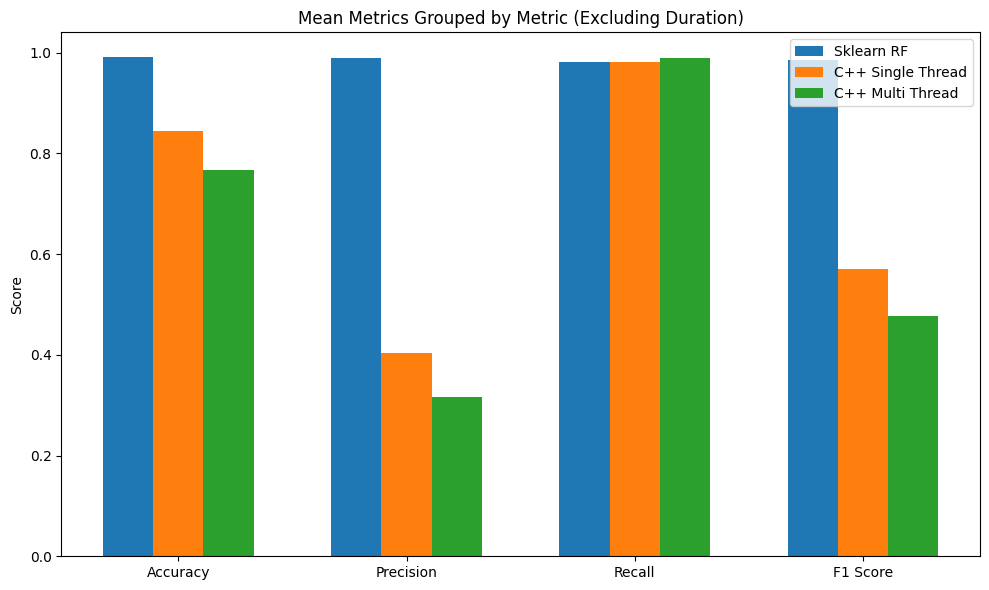

In [23]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
classifiers = ['Sklearn RF', 'C++ Single Thread', 'C++ Multi Thread']

# Exclude duration from metric_values
metric_values = [
    [sk_mean_accuracy, cpp_single_thread_mean_accuracy, cpp_multi_thread_mean_accuracy],
    [sk_mean_precision, cpp_single_thread_mean_precision, cpp_multi_thread_mean_precision],
    [sk_mean_recall, cpp_single_thread_mean_recall, cpp_multi_thread_mean_recall],
    [sk_mean_f_score, cpp_single_thread_mean_f_score, cpp_multi_thread_mean_f_score]
]

x = np.arange(len(labels))
width = 0.22

fig, ax = plt.subplots(figsize=(10, 6))
for i, classifier in enumerate(classifiers):
    ax.bar(x + (i - 1) * width, [metric[i] for metric in metric_values], width, label=classifier)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Score')
ax.set_title('Mean Metrics Grouped by Metric (Excluding Duration)')
ax.legend()
plt.tight_layout()

## Plotting results (Duration)

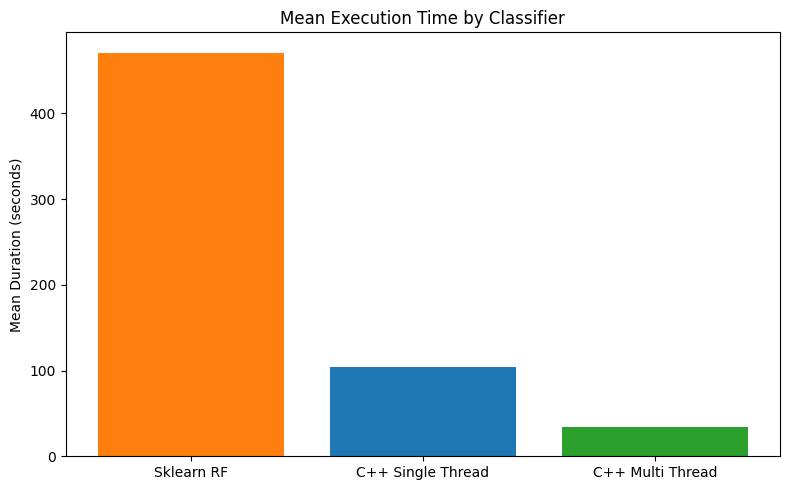

In [27]:
labels = ['Sklearn RF', 'C++ Single Thread', 'C++ Multi Thread']
mean_durations = [
    sk_mean_duration,
    cpp_single_thread_mean_duration,
    cpp_multi_thread_mean_duration
]

colors = ['#ff7f0e', '#1f77b4', '#2ca02c']

plt.figure(figsize=(8, 5))
plt.bar(labels, mean_durations, color=colors)
plt.ylabel('Mean Duration (seconds)')
plt.title('Mean Execution Time by Classifier')
plt.tight_layout()
plt.show()

## Single vs Multi Thread C++ Execution Time Comparison

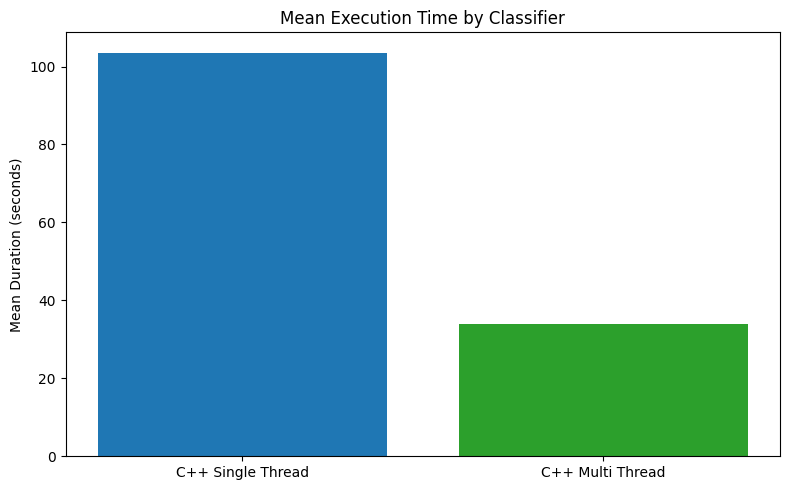

In [28]:
labels = [ 'C++ Single Thread', 'C++ Multi Thread']
mean_durations = [
    cpp_single_thread_mean_duration,
    cpp_multi_thread_mean_duration
]

colors = ['#1f77b4', '#2ca02c']

plt.figure(figsize=(8, 5))
plt.bar(labels, mean_durations, color=colors)
plt.ylabel('Mean Duration (seconds)')
plt.title('Mean Execution Time by Classifier')
plt.tight_layout()
plt.show()